# MACHINE LEARNING PROJECT HANDOUT

<h1 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Importing Libraries
</h1>

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<h1 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Reading the data
</h1>

In [8]:
df_cars_train = pd.read_csv("train.csv")

In [9]:
df_cars_test = pd.read_csv("test.csv")

In [10]:
df_cars_train.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [11]:
df_cars_test.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


In [12]:
df_cars_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Set CarID as index
</h3>

In [13]:
df_cars_train.set_index("carID")

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,Mercedes,C Class,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
6265,Audi,Q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
54886,Toyota,Aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0


In [14]:
df_cars_test.set_index("carID")

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105775,VW,Tiguan,2017.000000,Manual,27575.000000,Petrol,145.0,46.3,1.4,94.0,1.0,0.0
81363,BMW,X2,2020.000000,Automatic,1980.000000,Petrol,145.0,34.0,2.0,39.0,3.0,0.0
76833,Audi,Q5,2019.000000,Semi-Auto,8297.000000,Diesel,145.0,38.2,2.0,88.0,4.0,0.0


<h1 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Data Types
</h1>

Wrong data types: "year" should be "int64"
                "previous owners" should be "int64"
                "hasDamage" should be "boolean"

In [15]:
# fix wrong datatypes

# df_cars_train.year = df_cars_train.year.astype("int64")

df_cars_train["year"].isna().sum()

np.int64(1491)

In [16]:
# df_cars_train.previousOwners = df_cars_train.previousOwners.astype("int")
df_cars_train["previousOwners"].isna().sum()

np.int64(1550)

We can't fix the datatypes yet because we have a lot of missing values -> we should handle them first

In [17]:
df_cars_train.shape

(75973, 14)

In [133]:
df_cars_train.hasDamage = df_cars_train.hasDamage.astype("boolean")

In [19]:
df_cars_train.dtypes

carID               int64
Brand              object
model              object
year              float64
price               int64
transmission       object
mileage           float64
fuelType           object
tax               float64
mpg               float64
engineSize        float64
paintQuality%     float64
previousOwners    float64
hasDamage         boolean
dtype: object

<h1 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Duplicates
</h1>

In [20]:
df_cars_train.duplicated().sum()

np.int64(0)

No duplicates

<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Library for correcting spelling typos
</h3>

- *Brand*

In [74]:
car_brands = {
    "Volkswagen": ['VW', 'V', 'vw', 'v'],
    "Toyota": ['Toyota', 'Toyot', 'TOYOTA', 'oyota', 'toyota', 'OYOTA', 'TOYOT', 'toyot','oyot' ],
    "Audi": ['Audi', 'udi', 'AUDI', 'aud', 'audi', 'Aud', 'aud', 'UDI', 'ud', 'AUD'],
    "Ford": ['Ford', 'FOR', 'ord', 'For', 'FORD', 'ford', 'for', 'or', 'ORD'],
    "BMW": ['BMW', 'w', 'MW', 'bmw', 'BM', 'W', 'mw','bm'],
    "Skoda": ['Skoda', 'SKOD', 'koda', 'skoda', 'SKODA', 'Skod', 'kod', 'SKOD', 'KODA', 'skod'],
    "Opel": ['Opel', 'Ope', 'opel', 'pel', 'pe', 'OPEL', 'PEL', 'OPE', 'ope'],
    "Mercedes": ['Mercedes', 'mercedes', 'Mercede', 'MERCEDES', 'ercedes', 'mercede', 'ERCEDES', 'ercede', 'MERCEDE','M'],
    "Hyundai": ['Hyundai', 'yundai', 'Hyunda', 'hyundai', 'HYUNDAI', 'yunda', 'HYUNDA', 'hyunda','YUNDAI']
}


for brand, typos in car_brands.items():
    df_cars_train['Brand'] = df_cars_train['Brand'].apply(lambda x: brand if x in typos else x )
    df_cars_test['Brand'] = df_cars_test['Brand'].apply(lambda x: brand if x in typos else x )



df_cars_test['Brand'].unique()
# Brands: ['Mercedes', 'Opel', 'Ford', 'Volkswagen', 'Toyota', 'Unknown','BMW', 'Skoda', 'Audi', 'Hyundai']


array(['Hyundai', 'Volkswagen', 'BMW', 'Opel', 'Ford', 'Mercedes',
       'Skoda', 'Toyota', 'Audi', nan], dtype=object)

- *Model*

In [75]:
car_models = {
    "GOLF": ['Golf', 'Gol', ' GOLF', ' golf', ' golf s', ' Gol', ' Golf SV', ' golf sv', 'Golf', 'golf', ' GOLF', ' Golf S', ' gol', ' GOL', ' Golf'],
    "POLO": ['Polo', 'Pol', 'polo', ' POLO', ' polo', ' Pol', ' Polo', 'POLO'],
    "PASSAT": ['Passat', ' PASSAT', ' Passa', ' passa', ' Passa', ' Passa', ' passat', ' Passat'],
    "TIGUAN": ['Tiguan', ' Tiguan', ' TIGUAN', 'Tigua', ' tiguan', ' Tigua', ' TIGUA', ' tiguan', ' Tiguan', 'TIGUAN', 'tiguan'],
    "TIGUAN_ALLSPACE": [' tiguan allspace', ' Tiguan Allspac', 'Tiguan Allspace', ' TIGUAN ALLSPACE', ' Tiguan Allspace'],
    "TOUAREG": ['Touareg', ' TOUAREG', ' touareg', ' Touare', ' Touareg'],
    "T_ROC": ['T-Roc', ' T-Ro', ' t roc', ' T-Roc'],
    "T_CROSS": ['T-Cross', ' T-CROSS', ' t-cros', ' t cross', ' T-Cros', ' T-RO', ' T-ROC', ' t-roc', ' t-cross', 'T-Cross', ' T-Cross'],
    "ARTEON": ['Arteon', ' arteon', ' Arteo', ' ARTEON', ' Arteon'],
    "SHARAN": ['Sharan', ' sharan', ' SHARAN', ' Shara', ' Sharan', ' Sharan'],
    "JETTA": ['Jetta', ' Jetta', ' JETTA'],
    "CC": ['CC', ' cc', ' CC'],
    "CARAVELLE": ['Caravelle', ' caravelle', ' Caravell', ' Caravelle'],
    "CALIFORNIA": ['California', ' California'],
    "CADDY": ['Caddy', ' Caddy'],
    "CADDY_MAXI": ['Caddy Maxi Life', ' Caddy Maxi Lif', ' Caddy Maxi', ' Caddy Maxi Life', ' Caddy Life'],
    "TOURAN": ['Touran', ' touran', ' TOURAN', ' Touran', 'Toura', ' TOURA', ' Toura'],
    "GOLF_SV": ['Golf SV', 'Golf S', ' golf sv', ' GOLF SV', 'Golf SV'],
    "BEETLE": ['Beetle', ' beetle', ' Beetl', ' Beetle'],
    "SCIROCCO": ['Scirocco', ' scirocco', ' Scirocc', ' SCIROCCO', ' Scirocco'],
    "UP": ['Up', ' up', ' UP', ' Up', ' U', 'U', 'UP'],
    "AMAROK": ['Amarok', ' Amarok', ' amarok', ' Amaro'],
    "EOS": ['Eos', ' Eos'],
    "FOX": ['Fox', ' Fox'], "FOCUS": ['Focus', 'FOCUS', ' focus', ' FOCUS', ' FOCU', ' Focu', ' focu', ' Focus', 'Focu', 'focus'],
    "FIESTA": ['Fiesta', ' FIESTA', ' Fiest', 'fiesta', ' fiesta', ' Fiest', ' FIEST', ' fiest', ' Fiesta', 'Fiest'],
    "MONDEO": ['Mondeo', ' MONDEO', ' mondeo', ' Monde', ' MONDE', ' Mondeo'],
    "KUGA": ['Kuga', ' KUGA', ' kuga', ' Kug', ' kuga', ' Kuga', 'kuga'],
    "GALAXY": ['Galaxy', ' GALAXY', ' Galax', ' galax', ' Galaxy', ' galaxy'],
    "S_MAX": ['S-MAX', ' s-max', ' S-MA', ' s-ma', ' S-MAX'],
    "B_MAX": ['B-MAX', ' B-MA', ' b-max', ' B-MA', ' B-MAX', 'B-MA'],
    "ECOSPORT": ['EcoSport', ' ecosport', ' ECOSPORT', ' EcoSpor', ' EcoSport'],
    "PUMA": ['Puma', ' puma', ' PUMA', ' Puma'],
    "TOURNEO_CUSTOM": ['Tourneo Custom', ' tourneo custom', ' Tourneo Custo', ' Tourneo Custom'],
    "TOURNEO_CONNECT": ['Tourneo Connect', ' Grand Tourneo Connect', ' tourneo connect', ' Tourneo Connect'],
    "KA": ['Ka', ' KA', ' ka', ' Ka'],
    "KA_PLUS": [' Ka+', ' ka+', ' KA+', 'Ka+', 'ka+'],
    "C_MAX": ['C-MAX', ' C-MAX', ' c-max', ' C-MA'],
    "GRAND_C_MAX": [' Grand C-MAX', ' GRAND C-MAX', ' Grand C-MA', ' grand c-max'],
    "EDGE": ['Edge', ' edge', ' EDGE', ' Edge', ' Edg'],
    "MUSTANG": ['Mustang', ' mustang', ' Mustang'],
    "GRAND_TOURNEO_CONNECT": [' Grand Tourneo Connec'],
    "FUSION": ['Fusion', ' Fusion'],
    "STREETKA": ['Streeka', ' Streetka'],
    "RANGER": ['Ranger', ' Ranger'],
    "ESCORT": ['Escort', ' Escort'], "CORSA": ['Corsa', 'corsa', ' corsa', ' Cors', ' CORSA', ' cors', ' CORS', ' Corsa'],
    "ASTRA": ['Astra', 'ASTRA', 'astra', ' astra', ' ASTRA', ' ASTRA', ' Astr', 'Astra', ' Astra'],
    "INSIGNIA": ['Insignia', 'Insigni', ' INSIGNIA', ' insignia', ' Insigni', ' INSIGNI', ' Insignia'],
    "MOKKA": ['Mokka', 'Mokk', ' MOKKA', ' Mokka X', ' mokka', ' mokka x', ' MOKKA X', ' Mokk', ' Mokk', ' Mokka ', ' mokka ', ' Mokka X', ' Mokka', 'Mokka X'],
    "ZAFIRA": ['Zafira', ' zafira', ' ZAFIRA', ' Zafir', ' Zafira Tourer', ' Zafira Toure', ' ZAFIRA TOURER', 'Zafira Tourer', ' Zafira', 'Zafir'],
    "VIVA": ['Viva', ' viva', ' VIVA', ' Viva', ' Viv', ' Viva'],
    "MERIVA": ['Meriva', ' meriva', ' MERIVA', ' Meriv', ' Meriva'],
    "ADAM": ['Adam', ' adam', ' Ada', ' ADAM', ' Adam'],
    "COMBO_LIFE": ['Combo Life', 'COMBO LIFE', ' combo life', ' COMBO LIFE', ' Combo Lif', ' Combo Life'],
    "CROSSLAND_X": ['Crossland X', ' CROSSLAND X', ' crossland x', ' Crossland ', ' CrosslandX', ' Crossland X'],
    "GRANDLAND_X": ['Grandland X', ' Grandland X', ' grandland x', ' GRANDLAND X', ' Grandland ', ' grandland ', ' Grandland X'],
    "GTC": ['GTC', ' gtc', ' GTC', 'gtc'],
    "ANTARA": ['Antara', ' Antara'],
    "VIVARO": ['Vivaro', ' Vivaro'],
    "VECTRA": ['Vectra', ' Vectra', ' VECTRA'],
    "AGILA": ['Agila', ' Agila'],
    "TIGRA": ['Tigra', ' Tigra'],
    "CASCADA": ['Cascada', ' Cascada'],
    "AMPERA": ['Ampera', ' Ampera'], "SERIES_1": ['1 Series', '1 series', '1 SERIES', ' 1 Series', ' 1 SERIES', ' 1 serie', ' 1 Serie', ' 1 SERIE', ' 1 series'],
    "SERIES_2": ['2 Series', '2 Serie', ' 2 Series', ' 2 SERIES', ' 2 Serie', ' 2 serie', ' 2 series'],
    "SERIES_3": ['3 Series', '3 Serie', ' 3 Series', ' 3 SERIES', ' 3 Serie', ' 3 serie', ' 3 series'],
    "SERIES_4": ['4 Series', ' 4 serie', '4 series', ' 4 Series', ' 4 SERIES', ' 4 Serie', ' 4 series'],
    "SERIES_5": ['5 Series', '5 SERIES', ' 5 Series', ' 5 SERIES', ' 5 Serie', ' 5 series'],
    "SERIES_6": ['6 Series', ' 6 Series', ' 6 SERIES', ' 6 Serie', ' 6 series'],
    "SERIES_7": ['7 Series', ' 7 Series', ' 7 SERIES', ' 7 Serie', ' 7 series'],
    "SERIES_8": ['8 Series', ' 8 SERIES', '8 SERIES', ' 8 Serie', ' 8 Series', ' 8 series'],
    "X1": ['X1', ' x1', ' X1', 'x1'],
    "X2": ['X2', ' IX2', ' x2', ' X2'],
    "X3": ['X3', ' x3', ' X3'],
    "X4": ['X4', ' x4', ' X4'],
    "X5": ['X5', ' x5', ' X5'],
    "X6": ['X6', ' x6', ' X6'],
    "X7": ['X7', ' x7', ' X7'],
    "Z3": ['Z3', ' Z3'],
    "Z4": ['Z4', ' z4', ' Z4'],
    "M2": ['M2', ' M2'],
    "M3": ['M3', ' m3', ' M3'],
    "M4": ['M4', ' m4', ' M4'],
    "M5": ['M5', ' M5'],
    "M6": ['M6', ' M6'], "A1": ['A1', ' a1', ' A1'],
    "A2": ['A2', ' A2'],
    "A3": ['A3', ' a3', ' A 3', ' A3', ' a3'],
    "A4": ['A4', ' a4', ' A4', ' a4'],
    "A5": ['A5', ' a5', ' A5'],
    "A6": ['A6', ' A6', ' a6'],
    "A7": ['A7', ' a7', ' A7'],
    "A8": ['A8', ' A8', 'a8'],
    "Q2": ['Q2', ' q2', ' Q2'],
    "Q3": ['Q3', ' q3', ' Q3'],
    "Q5": ['Q5', ' q5', ' Q5', ' q5', 'q5'],
    "Q7": ['Q7', ' q7', ' Q7'],
    "Q8": ['Q8', ' q8', ' Q8'],
    "S3": ['S3', ' s3', ' S3'],
    "S4": ['S4', ' S4'],
    "S5": ['S5', ' S5'],
    "S8": ['S8', ' S8'],
    "RS3": ['RS3', ' RS3'],
    "RS4": ['RS4', ' RS4'],
    "RS5": ['RS5', ' RS5'],
    "RS6": ['RS6', ' RS6'],
    "SQ5": ['SQ5', ' SQ5'],
    "SQ7": ['SQ7', ' SQ7', ' sq7'],
    "TT": ['TT', ' TT', ' tt', ' T'],
    "R8": ['R8', ' r8', ' R8'],  "A_CLASS": ['A-Class', 'a class', 'A CLASS', ' A-Class', ' a class', ' A CLASS', 'A Clas', ' a clas', 'A-Class', ' A Class', 'A CLASS', 'A Clas', ' a class', ' A Class', 'A CLASS', ' A Clas', ' a class', 'A Class'],
    "B_CLASS": ['B-Class', 'b class', 'B CLASS', ' b class', ' B Clas', ' B Class', ' B CLASS', ' b class', 'B Class'],
    "C_CLASS": ['C-Class', 'C Clas', 'C CLASS', 'c class', ' c class', ' C Class', ' C Clas', ' c clas', ' C Class', 'C CLASS', ' c class', ' C CLAS', ' C CLASS', 'C Class'],
    "E_CLASS": ['E-Class', 'E CLASS', ' E Clas', ' e class', 'E Class', 'E-Class', ' E Class', 'E CLASS', ' e class', ' E Class', 'E CLASS', ' e class', ' E CLASS', 'e class'],
    "S_CLASS": ['S-Class', 'S Class', 'S CLASS', ' s class', ' S Clas', ' S Class', 'S CLASS', ' S CLASS'],
    "CLA_CLASS": ['CLA-Class', ' CLA CLASS', 'CLA CLASS', 'CLA Class', ' cla class', ' CLA Class', ' CLA Class'],
    "CLS_CLASS": ['CLS-Class', 'CLS Class', 'CLS CLASS', ' cls class', ' CL Class', ' cl class', ' CL CLASS', ' CL Clas', ' CLS Class', ' CLS CLASS', ' CLS Clas'],
    "GLA_CLASS": ['GLA-Class', ' GLA CLASS', 'GLA CLASS', ' gla class', ' GLA Class', ' GLA Clas', 'GLA Class'],
    "GLB_CLASS": ['GLB-Class', ' glb class', 'GLB Class', ' GLB Class'],
    "GLC_CLASS": ['GLC-Class', 'GLC CLASS', ' glc class', ' GLC Class', ' glc clas', ' GLC Class', ' GLC CLASS', ' GLC Clas', 'GLC Class'],
    "GLE_CLASS": ['GLE-Class', ' GLE CLASS', 'GLE CLASS', 'GLE Class', ' gle class', ' GLE Clas', ' GLE Class', 'GLE CLASS'],
    "GLS_CLASS": ['GLS-Class', 'GLS CLASS', ' GLS Class', ' GLS CLASS', ' GLS Clas', ' gls class'],
    "GL_CLASS": ['GL-Class', 'GL Class', ' GL Class', ' GL CLASS', ' gl class'],
    "G_CLASS": ['G-Class', ' G Class'],
    "V_CLASS": ['V-Class', 'V CLASS', ' v class', ' V Clas', ' V Class', ' V CLASS', 'V Class'],
    "X_CLASS": ['X-Class', ' x-class', ' x-clas', ' X Clas', ' X-CLASS', ' X-CLAS'],
    "SL_CLASS": ['SL-Class', ' SL CLASS', 'SL CLASS', ' sl class', ' SL CLAS', ' SL CLASS', ' SL'],
    "SLK_CLASS": ['SLK-Class', 'SLK', ' slk', ' SLK'],
    "M_CLASS": ['M-Class', ' M CLASS', ' m class', 'M Class', ' M Class', ' M Clas'],
    "CLK": ['CLK', ' CLK'],
    "CL_CLASS": ['CL Class'],
    "CLC_CLASS": ['CLC Class', ' CLC Class'],
    "MERCEDES200": ['200', ' 200'],
    "MERCEDES230": ['230', ' 230'],
    "MERCEDES220": ['220', ' 220'],   "YARIS": ['Yaris', 'yaris', ' yaris', 'Yari', ' YARIS', ' Yari', ' Yaris', ' yari', ' Yari', ' YARI'],
    "AYGO": ['Aygo', ' AYGO', ' aygo', 'aygo', ' Ayg', ' AYG', ' ayg', ' Aygo'],
    "COROLLA": ['Corolla', ' COROLLA', ' corolla', ' Coroll', ' Corolla', 'corolla'],
    "C_HR": ['C-HR', ' c-hr', ' C-HR', ' C-H'],
    "AVENSIS": ['Avensis', ' AVENSIS', ' avensis', ' Avensis'],
    "PRIUS": ['Prius', ' PRIUS', ' prius', ' Prius'],
    "RAV4": ['RAV4', ' RAV', ' rav', ' rav4', ' RAV4', 'rav4', 'RAV'],
    "HILUX": ['Hilux', ' hilux', ' Hilu', ' Hilux'],
    "VERSO": ['Verso', ' verso', ' VERSO', ' Verso-S', ' Vers', ' Verso'],
    "SUPRA": ['Supra', ' Supra', 'Supra'],
    "LAND_CRUISER": ['Land Cruiser', ' Land Cruise', ' Land Cruiser'],
    "CAMRY": ['Camry', ' Camry'],
    "PROACE_VERSO": ['Proace Verso', ' PROACE VERSO'],
    "URBAN_CRUISER": ['Urban Cruiser', ' Urban Cruiser', ' Urban Cruise'],
    "AURIS": ['Auris', ' auris', ' AURI', ' AURIS', ' Auri', ' Auris'],
    "GT86": [' GT86', 'GT86', ' gt86'], "I10": ['i10', ' i10', 'I10', ' I1', ' I10', ' I1'],
    "I20": ['i20', 'I20', ' I20', ' i20', ' I2'],
    "I30": ['i30', ' i30', 'I30', ' I30', 'I3', ' i3', 'i3', ' I3'],
    "I40": ['i40', 'I40', ' i40', ' I40', ' I40'],
    "I800": ['i800', ' I80', 'I800', ' i800', ' I800', 'i8', ' I8', ' i8'],
    "IONIQ": ['Ioniq', ' ioniq', ' IONIQ', ' Ioni', ' Ioniq', ' IQ', 'IONIQ'],
    "KONA": ['Kona', ' KONA', ' kona', ' KON', ' Kona', ' Kon'],
    "TUCSON": ['Tucson', 'Tucso', ' tucson', ' Tucso', ' TUCSON', ' TUCSO', ' Tucso', ' TUCSO', ' TUCSON', ' Tucson'],
    "SANTA_FE": ['Santa Fe', ' santa fe', ' Santa Fe', ' SANTA FE', ' Santa F'],
    "GETZ": ['Getz', ' Getz'],
    "IX20": ['ix20', 'IX20', ' IX20', ' ix20'],
    "IX35": ['ix35', ' IX35', 'IX35', ' ix35'],
    "VELOSTER": ['Veloste', ' Veloste'],
    "ACCENT": ['Accent', ' Accent'],
    "TERRACAN": ['Terracan', ' Terracan'],  "FABIA": ['Fabia', ' FABIA', ' fabia', ' Fabi', ' Fabia', 'FABIA'],
    "OCTAVIA": ['Octavia', ' OCTAVIA', ' octavia', 'octavia', 'Octavi', ' octavia', ' Octavi', ' Octavia'],
    "SUPERB": ['Superb', ' superb', ' SUPERB', ' super', ' Super', ' Superb'],
    "KAROQ": ['Karoq', ' karoq', ' Karo', ' KAROQ', ' Karoq'],
    "KODIAQ": ['Kodiaq', 'kodiaq', ' kodiaq', ' KODIAQ', ' Kodia', ' Kodiaq'],
    "KAMIQ": ['Kamiq', ' KAMIQ', ' kamik', ' kamiq', ' KAMI', ' Kamiq'],
    "YETI": ['Yeti', ' yeti', ' Yeti Outdoo', ' yeti outdoor', ' Yeti Outdoor', 'Yeti Outdoor', ' YETI OUTDOOR', ' Yet', ' Yeti'],
    "SCALA": ['Scala', ' scala', ' Scal', ' SCALA', ' scal', ' Scala'],
    "RAPID": ['Rapid', ' rapid', ' Rapi', ' Rapi', ' Rapid'],
    "CITIGO": ['Citigo', ' citigo', ' CITIGO', ' Citig', ' Citigo'],
    "ROOMSTER": ['Roomster', ' Roomste', ' Roomster'],  "LEON": ['Leon'],
        "ATECA": ['Ateca'],
        "TOLEDO": ['Toledo'],
        "ARONA": ['Arona'],
        "IBIZA": ['Ibiza'],
        "ALHAMBRA": ['Alhambra'], "SHUTTLE": ['Shuttle', ' Shuttle', ' shuttle'],
        "KADJAR": ['Kadjar', ' Kadjar']
}


for model, typos in car_models.items():
    df_cars_train['model'] = df_cars_train['model'].apply(lambda x: model if x in typos else x )
    df_cars_test['model'] = df_cars_test['model'].apply(lambda x: model if x in typos else x )

df_cars_train['model'].unique()

array(['GOLF', 'YARIS', 'Q2', 'FIESTA', 'SERIES_2', 'SERIES_3', 'A3',
       'OCTAVIA', 'PASSAT', 'FOCUS', 'INSIGNIA', 'A_CLASS', 'Q3', 'FABIA',
       'KA_PLUS', 'GLC_CLASS', 'I30', 'C_CLASS', 'POLO', 'E_CLASS', 'Q5',
       'UP', 'C_HR', 'MOKKA', 'CORSA', 'ASTRA', 'TT', 'SERIES_5', 'AYGO',
       'SERIES_4', 'SLK_CLASS', 'VIVA', 'T_ROC', 'ECOSPORT', 'TUCSON',
       nan, 'X_CLASS', 'CLS_CLASS', 'IX20', 'I20', 'RAPID', 'A1', 'AURIS',
       'SHARAN', 'ADAM', 'X3', 'A8', 'GLS_CLASS', 'B_MAX', 'A4', 'KONA',
       'I10', 'S_MAX', 'X2', 'CROSSLAND_X', 'TIGUAN', 'A5', 'GLE_CLASS',
       'ZAFIRA', 'IONIQ', 'A6', 'MONDEO', 'YETI', 'X1', 'SCALA',
       'S_CLASS', 'SERIES_1', 'KAMIQ', 'KUGA', 'TOURNEO_CONNECT', 'Q7',
       'GLA_CLASS', 'ARTEON', 'SL_CLASS', 'SANTA_FE', 'GRANDLAND_X',
       'I800', 'RAV4', 'TOURAN', 'CITIGO', 'ROOMSTER', 'PRIUS', 'COROLLA',
       'B_CLASS', ' Q', 'KODIAQ', 'V_CLASS', 'CADDY_MAXI', 'SUPERB',
       'GETZ', 'COMBO_LIFE', 'BEETLE', 'GALAXY', 'M3', 'GTC', 'X4

- *Transmission*

In [76]:
transmission_types = {
    "Semi_auto": ['Semi-Auto', 'Semi-Aut', 'SEMI-AUTO', 'semi-auto', 'emi-auto', 'SEMI-AUT', 'emi-auto', 'emi-Aut', 'semi-aut', 'EMI-AUTO', 'emi-Auto'],
    "Manual": ['Manual', 'Manua', 'MANUAL', 'manual', 'anual', 'Manual', 'ANUAL', 'Manual ', ' manual ', 'anua', ' MANUAL ', 'MANUA', 'manua', ' Manual', 'manual ', ' Manual '],
    "Automatic": ['Automatic', 'Automati', 'utomatic', 'AUTOMATIC', 'automatic', 'AUTOMATI', 'automati', 'UTOMATIC', 'utomati'],
    "Unknown": ['Unknown', 'unknown', 'nknown', 'UNKNOWN', 'nknow', 'unknow'] }


for trans, typos in transmission_types.items():
    df_cars_train['transmission'] = df_cars_train['transmission'].apply(lambda x: trans if x in typos else x )
    df_cars_test['transmission'] = df_cars_test['transmission'].apply(lambda x: trans if x in typos else x )

df_cars_train['transmission'].unique()

array(['Semi_auto', 'Manual', 'Automatic', nan, 'Unknown', 'Other'],
      dtype=object)

- *FuelType*

In [77]:
fuel_types = {
    "Diesel": ['Diesel', 'Diese', 'iesel', 'DIESEL', 'diesel', 'diese', 'IESEL', 'DIESE', 'iese', 'IESE'],
    "Petrol": ['petrol', 'Petrol', 'ETROL', 'Petro', 'etrol', 'PETROL', 'PETRO', 'etro', 'petro', 'ETRO'],
    "Hybrid": ['Hybrid', 'hybrid', 'Hybri', 'HYBRID', 'ybrid', 'HYBRI', 'ybri', 'YBRID','hybri'],
    "Other": ['Other', 'OTHER', 'Othe', 'ther', 'other']
}

for fuel, typos in fuel_types.items():
    df_cars_train['fuelType'] = df_cars_train['fuelType'].apply(lambda x: fuel if x in typos else x )
    df_cars_test['fuelType'] = df_cars_test['fuelType'].apply(lambda x: fuel if x in typos else x )



df_cars_train['fuelType'].unique() #fuelType categories:  '['Diesel', 'Petrol', 'Hybrid', 'Unknown', 'Other', 'Electric']


array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

<h2 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Logical errors
</h2>

Check numerical categories for numbers smaller than 0

In [21]:
# Numeric variables
numeric_train = df_cars_train.select_dtypes(include=['number']).columns
numeric_train

Index(['carID', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'paintQuality%', 'previousOwners'],
      dtype='object')

In [22]:
neg_counts = (df_cars_train[numeric_train] < 0).sum()
neg_counts

carID               0
year                0
price               0
mileage           369
tax               378
mpg                36
engineSize         84
paintQuality%       0
previousOwners    371
dtype: int64

In [23]:
# in percentage of the total amount of observations

neg_counts_percentage = neg_counts/len(df_cars_train)*100
neg_counts_percentage

carID             0.000000
year              0.000000
price             0.000000
mileage           0.485699
tax               0.497545
mpg               0.047385
engineSize        0.110566
paintQuality%     0.000000
previousOwners    0.488331
dtype: float64

<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Remove cars from 1970 because one of them is automatic (error) and they are very far apart from all the other cars (outliers)
</h3>

In [79]:
df_cars_train.drop(df_cars_train[df_cars_train['year'] == 1970].index, inplace=True)

In [80]:
df_cars_train[df_cars_train["year"]==1970]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage


<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Remove mpg for eletric cars
</h3>

In [81]:
df_cars_test[df_cars_test["fuelType"]=="Eletric"] 
# there are no eletric cars

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage


<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Replace the years > 2020 by NA
</h3>

In [82]:
df_cars_train.loc[df_cars_train["year"] > 2020, "year"] = np.nan

In [83]:
df_cars_train[df_cars_train["year"].isna()]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
26,35263,Mercedes,C_CLASS,NaN,11295,Automatic,45000.0,Petrol,-56.193202,46.3,1.6,59.0,NaN,False
35,53282,Toyota,YARIS,NaN,16995,Manual,1225.0,Petrol,145.000000,47.9,1.5,77.0,0.0,False
44,68423,Volkswagen,POLO,NaN,10328,NaN,26941.0,Petrol,145.000000,60.1,1.2,97.0,4.0,False
182,49731,Skoda,OCTAVIA,NaN,11990,Manual,35650.0,NaN,30.000000,55.4,1.4,68.0,3.0,False
192,38604,Mercedes,E_CLASS,NaN,34980,Semi_auto,4196.0,Diesel,145.000000,70.6,2.0,44.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75783,67270,Volkswagen,POLO,NaN,6880,Semi_auto,44551.0,Petrol,145.000000,47.9,1.4,92.0,2.0,False
75824,61087,Opel,NaN,NaN,14295,Manual,14609.0,Petrol,145.000000,39.2,1.4,50.0,2.0,False
75897,62592,Opel,ASTRA,NaN,10295,Manual,10271.0,Petrol,145.000000,62.8,1.0,99.0,3.0,False
75898,2568,Audi,Q,NaN,27790,Automatic,6000.0,Diesel,145.000000,46.3,2.0,87.0,1.0,False


<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Paint Quality > 100%
</h3>

In [84]:
filtered = df_cars_train[df_cars_train["paintQuality%"]>100]
filtered

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
171,15717,Ford,FIESTA,2018.0,10491,Manual,6522.0,Petrol,145.0,65.7,1.0,125.109951,3.0,False
194,11200,BMW,SERIES_4,2019.0,23591,Semi_auto,6100.0,Petrol,145.0,45.6,2.0,125.569499,2.0,False
272,53403,Toyota,AYGO,2016.0,7995,Manual,25300.0,NaN,0.0,69.0,1.0,125.594308,1.0,False
467,48038,Skoda,YETI,2015.0,11995,Semi_auto,19805.0,Petrol,125.0,51.4,1.2,125.453599,1.0,False
583,10137,BMW,SERIES_5,2017.0,21995,Automatic,18820.0,Diesel,145.0,65.7,2.0,125.569499,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74763,75768,Volkswagen,TIGUAN,2018.0,18499,Manual,24940.0,Petrol,145.0,48.7,1.4,125.366507,0.0,False
75073,39666,Mercedes,E_CLASS,2017.0,21602,Semi_auto,40690.0,Diesel,145.0,NaN,3.0,125.202033,3.0,False
75135,23930,Ford,FIESTA,2020.0,15000,Manual,35.0,Petrol,145.0,56.5,1.0,125.109951,0.0,False
75540,38756,Mercedes,GLS_CLASS,2016.0,36495,Semi_auto,33000.0,Diesel,300.0,37.2,3.0,125.202033,2.0,False


<Axes: xlabel='paintQuality%', ylabel='Count'>

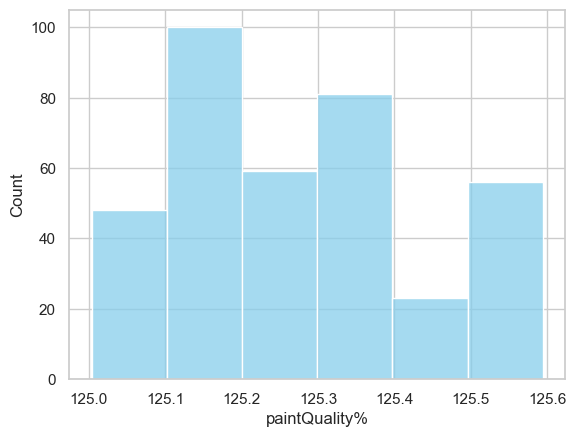

In [95]:
## Histogram of abnormal paint quality
sns.set(style="whitegrid")
sns.histplot(data=filtered,x='paintQuality%',bins=6,color='skyblue',edgecolor='white')

This histogram shows that the observations of the invalid paint quality of the cars are all at 125%. Let's check if these abnormal values are correlated with the year (eg older cars are misrecorded) or brand (specific brands).

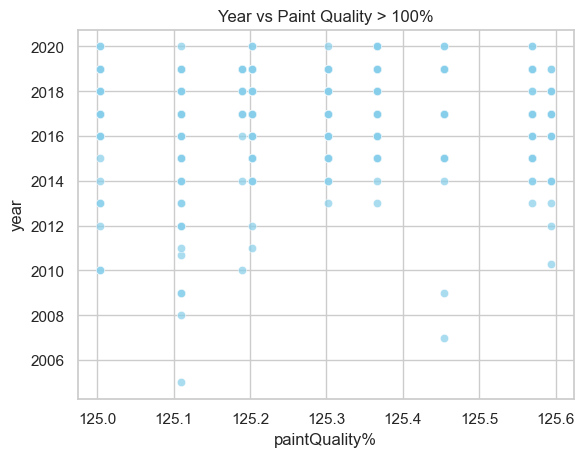

In [86]:
sns.scatterplot(data=filtered, x='paintQuality%', y='year', alpha=0.7, color = 'skyblue')
plt.title('Year vs Paint Quality > 100%')
plt.show()

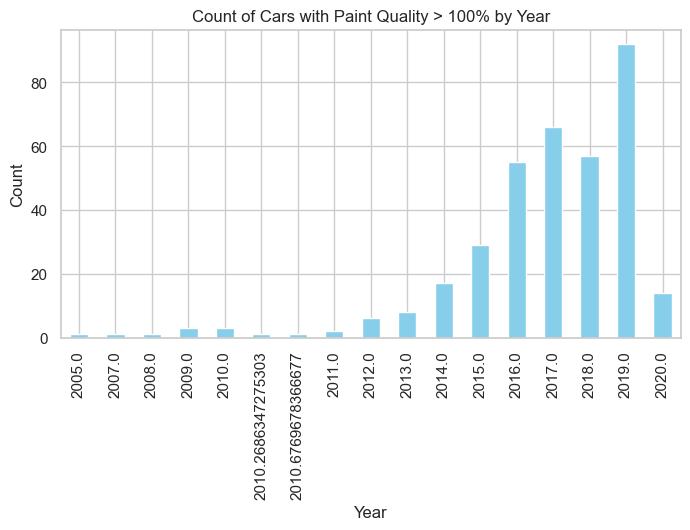

In [87]:
invalid_counts = filtered['year'].value_counts().sort_index()

plt.figure(figsize=(8,4))
invalid_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Cars with Paint Quality > 100% by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

The errors have occured in the most recent years. We see that although most of the invalid erros are in 2019, there is not a specific correlation with the year.

Most of the invalid numbers are Fords, VW, Mercedes, Opel

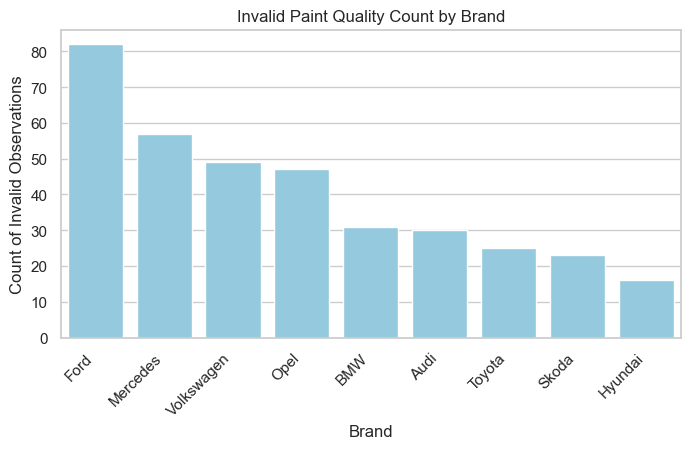

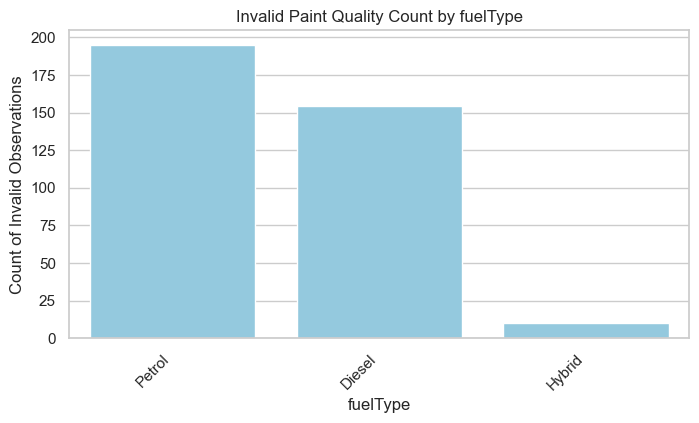

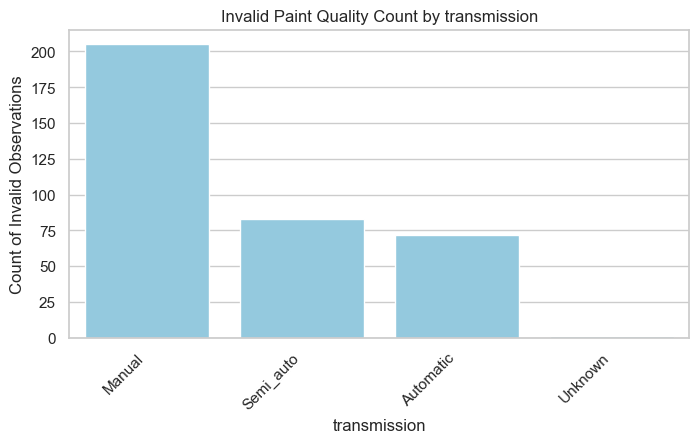

In [96]:
categorical_cols = ['Brand', 'fuelType', 'transmission'] 

for col in categorical_cols:
    invalid_counts = filtered[col].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=invalid_counts.index, y=invalid_counts.values, color='skyblue')
    plt.title(f'Invalid Paint Quality Count by {col}')
    plt.xlabel(col)
    plt.ylabel('Count of Invalid Observations')
    plt.xticks(rotation=45, ha='right')
    plt.show()

There is no direct relation between PaintQuality% > 100 and a certain year or brand, so we should turn these values into NA and input the mode of the brand, for example. 

<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    PreviousOwners Float
</h3>

In [89]:
df_cars_train["previousOwners"].unique()

array([ 4.        ,  1.        , -2.34030622,  3.        ,  0.        ,
        2.        ,         nan, -2.34565   ,  6.25837066, -2.33512284,
        6.22789796,  6.25823052,  6.23017958, -2.33936045,  6.21772443,
        6.24583495, -2.29943868, -2.34010209, -2.31225953,  6.2482512 ,
       -2.31733109,  6.23308217,  6.24177863, -2.33744529])

All the positive floats for this variable are around 6.2

/var/folders/d1/8t60fw413gvf0w3kz4s86s7w0000gn/T/ipykernel_3572/3784466104.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive['owner_type'] = df_positive['previousOwners'].apply(


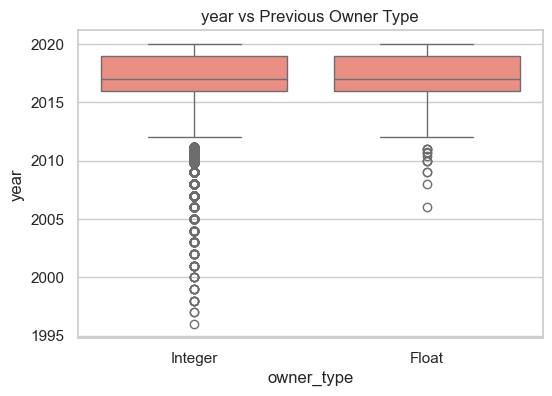

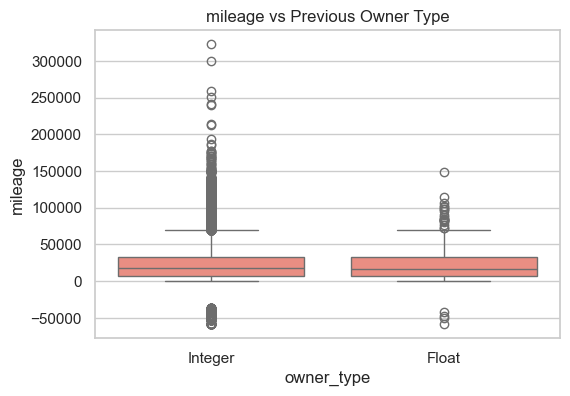

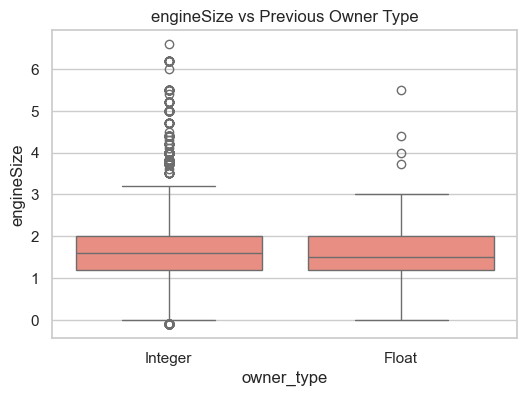

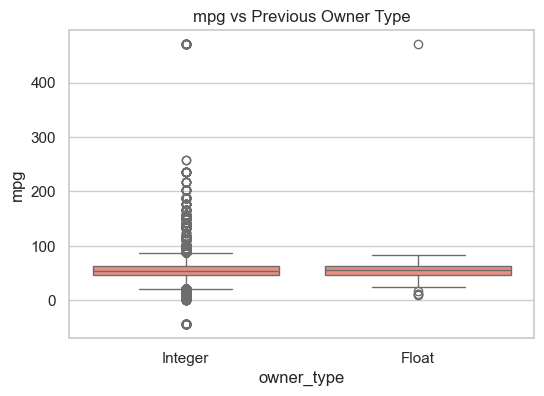

In [97]:
# Exclude negative values
df_positive = df_cars_train[df_cars_train['previousOwners'] >= 0]
# Identify floats (non-integer) vs integers
float_rows = df_positive[df_positive['previousOwners'] % 1 != 0]
int_rows = df_positive[df_positive['previousOwners'] % 1 == 0]

# Add a label column for clarity
df_positive['owner_type'] = df_positive['previousOwners'].apply(
    lambda x: 'Float' if x % 1 != 0 else 'Integer')

# Choose numeric columns to compare
num_cols = ['year', 'mileage', 'engineSize', 'mpg']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_positive, x='owner_type', y=col, color='salmon')
    plt.title(f'{col} vs Previous Owner Type')
    plt.show()


For the numeric variables, the behavior of integer vs float is basically the same. Now let's see if we can spot anything based on the categorical variables.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


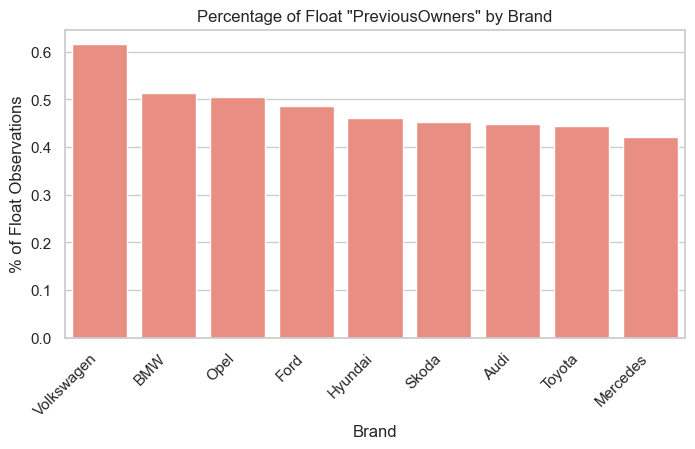

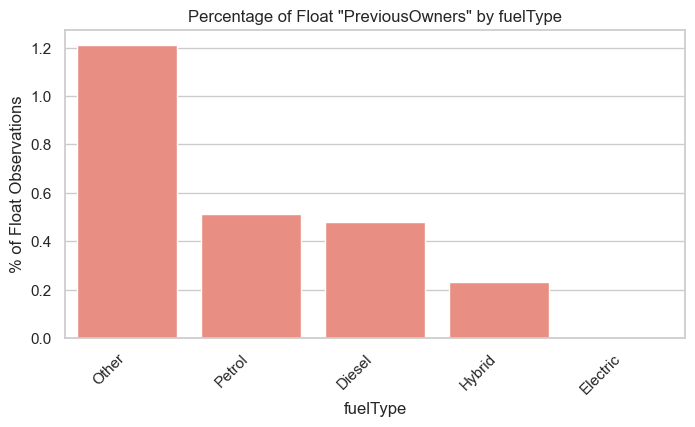

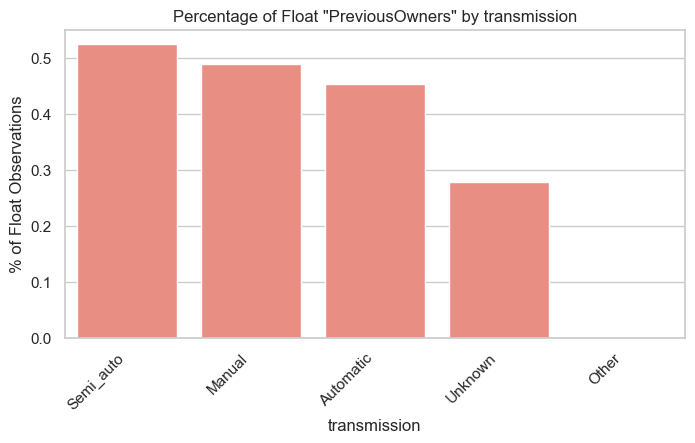

In [93]:
cat_cols = ['Brand', 'fuelType', 'transmission']

for col in cat_cols:
    proportion = (
        df_positive.groupby(col)['owner_type']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .sort_values('Float', ascending=False)
    )
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=proportion.index, y=proportion['Float'] * 100, color='salmon')
    plt.title(f'Percentage of Float "PreviousOwners" by {col}')
    plt.ylabel('% of Float Observations')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.show()

There is no category in which the number of floats is much higher than the others, except for fuelType. In this case, we should convert them to NA.

<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Negative vs Positive Values
</h3>

In [100]:
# Isolate the columns with negative numbers
numeric_cols = ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']

In [101]:
# Create a summary table for each numeric variable showing how many negative, zero, and positive values exist
summary = pd.DataFrame(columns=['Variable', 'Negative', 'Zero', 'Positive', 'Total'])

for col in numeric_cols:
    neg = (df_cars_train[col] < 0).sum()
    zero = (df_cars_train[col] == 0).sum()
    pos = (df_cars_train[col] > 0).sum()
    total = len(df_cars_train[col])
    summary = pd.concat([summary, pd.DataFrame({
        'Variable': [col],
        'Negative': [neg],
        'Zero': [zero],
        'Positive': [pos],
        'Total': [total]
    })])

summary['NegPct'] = summary['Negative'] / summary['Total'] * 100
summary['PosPct'] = summary['Positive'] / summary['Total'] * 100
summary

,Variable,Negative,Zero,Positive,Total,NegPct,PosPct
0,mileage,369,0,74139,75971,0.485712,97.588554
0,tax,378,4320,63369,75971,0.497558,83.412091
0,mpg,36,0,68009,75971,0.047387,89.519685
0,engineSize,84,179,74193,75971,0.110569,97.659633
0,paintQuality%,0,0,74447,75971,0.0,97.993971
0,previousOwners,371,14879,59171,75971,0.488344,77.886299


None of the negative values make sense in this context. 
Zeros: make sense in tax (cars that didn't pay any road tax) and previousOwners (new cars). **Idea for feature engineering: new vs used car**. Doesn't make sense in engineSize.

In [105]:
## Statistical Summary
neg_stats = df_cars_train[numeric_cols][df_cars_train[numeric_cols] < 0].describe()
pos_stats = df_cars_train[numeric_cols][df_cars_train[numeric_cols] > 0].describe()
# doesn't give us much information considering variable behavior, since they are numeric

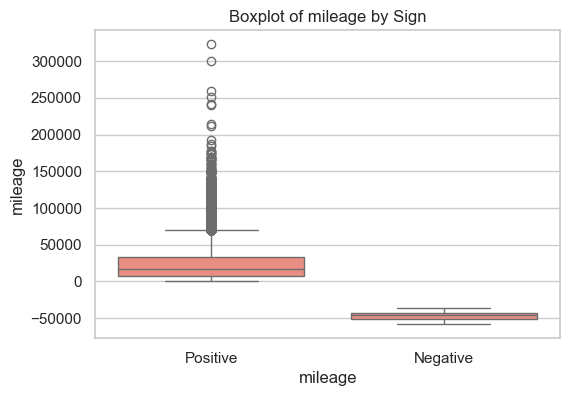

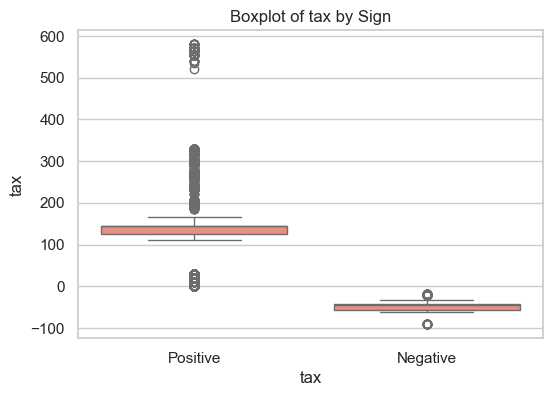

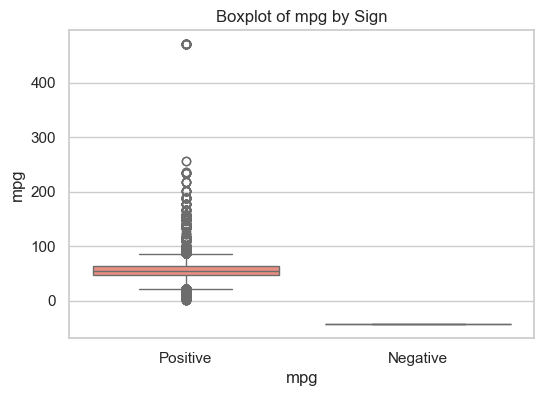

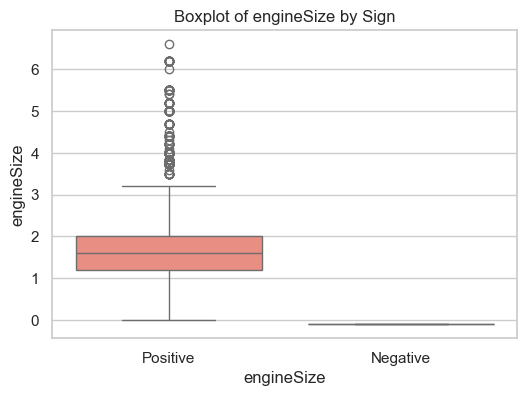

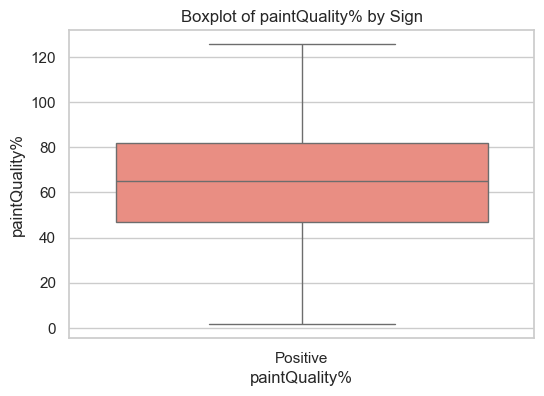

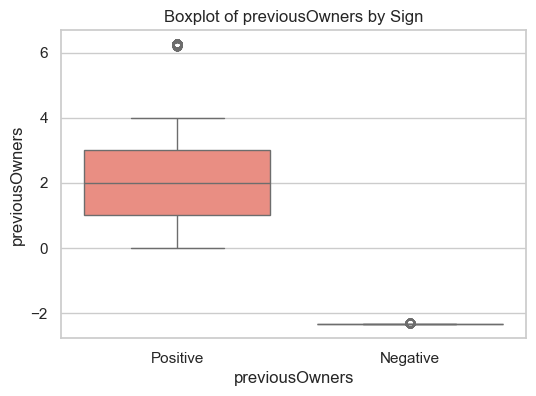

In [113]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=(df_cars_train[col] < 0).map({True:'Negative', False:'Positive'}), y=df_cars_train[col], color='salmon')
    plt.title(f'Boxplot of {col} by Sign')
    plt.show()

Obviously the boxplots of the negative numbers are going to be centered around negative numbers. I'm not sure what kind of conclusions we can draw from negative vs positive distributions.

<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
EngineSize = 0
</h3>

In [115]:
filtered = df_cars_train[df_cars_train["engineSize"]==0]
filtered

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
64,30317,Ford,NaN,2019.0,9999,Manual,10000.0,Petrol,145.0,47.9,0.0,61.0,3.0,False
759,21935,Ford,KA,2018.0,8444,Manual,17000.0,Petrol,145.0,57.7,0.0,51.0,0.0,False
1039,9518,BMW,SERIES_2,2015.0,14700,Automatic,32882.0,Diesel,125.0,60.1,0.0,55.0,0.0,False
1057,32528,Hyundai,TUCSON,2016.0,13800,Manual,27311.0,Diesel,30.0,61.7,0.0,73.0,1.0,False
1519,33804,Hyundai,TUCSON,2019.0,15000,Manual,22397.0,Petrol,150.0,34.9,0.0,54.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74469,26630,Ford,FIESTA,2018.0,11463,NaN,18000.0,Petrol,145.0,65.7,0.0,82.0,0.0,False
75168,20128,Ford,FOCUS,2018.0,18389,Manual,19000.0,Petrol,NaN,NaN,0.0,48.0,2.0,False
75401,47605,Skoda,FABIA,2018.0,11500,Manual,10720.0,Petrol,150.0,64.2,0.0,84.0,4.0,False
75405,33307,Hyundai,I10,2018.0,8500,Manual,12948.0,Petrol,145.0,60.1,0.0,46.0,2.0,False


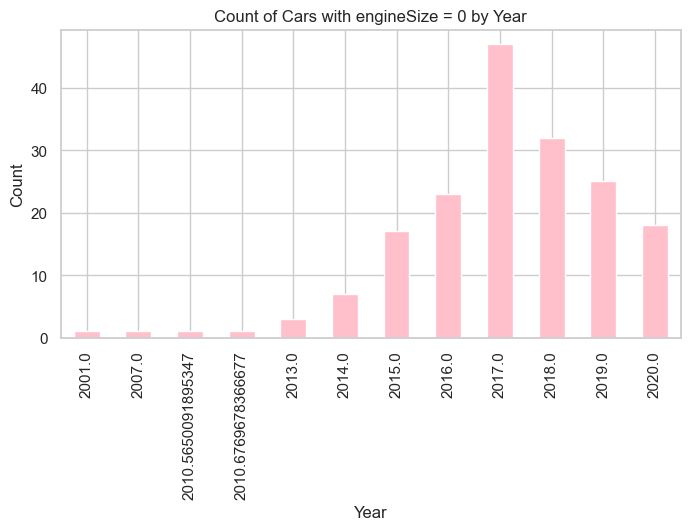

In [122]:
df_zero = filtered['year'].value_counts().sort_index()

plt.figure(figsize=(8,4))
df_zero.plot(kind='bar', color='pink')
plt.title('Count of Cars with engineSize = 0 by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

We see that there is a peak in 2017. It would be interesting to analyze the relative frequency of engineSize = 0 in each year in regards to the total number of cars from that year.

/var/folders/d1/8t60fw413gvf0w3kz4s86s7w0000gn/T/ipykernel_3572/2474482009.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int_years['year'] = df_int_years['year'].astype(int)


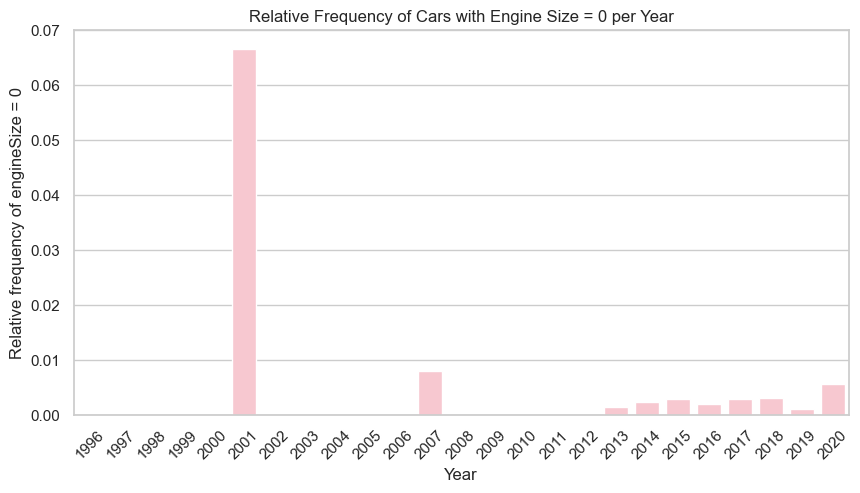

In [127]:
# Computing Relative Frequency per Year

# Filter for integer years
df_int_years = df_cars_train[df_cars_train['year'].notna() & (df_cars_train['year'] % 1 == 0)]
df_int_years['year'] = df_int_years['year'].astype(int)

# Filter cars with engineSize = 0
df_zero = df_int_years[df_int_years['engineSize'] == 0]

# Count total cars per year
total_per_year = df_int_years.groupby('year').size()

# Count cars with engineSize = 0 per year
zero_per_year = df_zero.groupby('year').size()

# Compute relative frequency
rel_freq = (zero_per_year / total_per_year).fillna(0)

# Convert to DataFrame for plotting
rel_freq_df = rel_freq.reset_index().rename(columns={0: 'relative_freq'})
rel_freq_df.columns = ['year', 'relative_freq']

# Plot barplot

plt.figure(figsize=(10,5))
sns.barplot(x='year', y='relative_freq', data=rel_freq_df, color='pink')
plt.ylabel('Relative frequency of engineSize = 0')
plt.xlabel('Year')
plt.title('Relative Frequency of Cars with Engine Size = 0 per Year')
plt.xticks(rotation=45)
plt.show()

You can see  that it peaks in 2001, but it's still less than 1% of the cars of that year. So we cant convert these to NA

Let's see if there is any category that stands out.

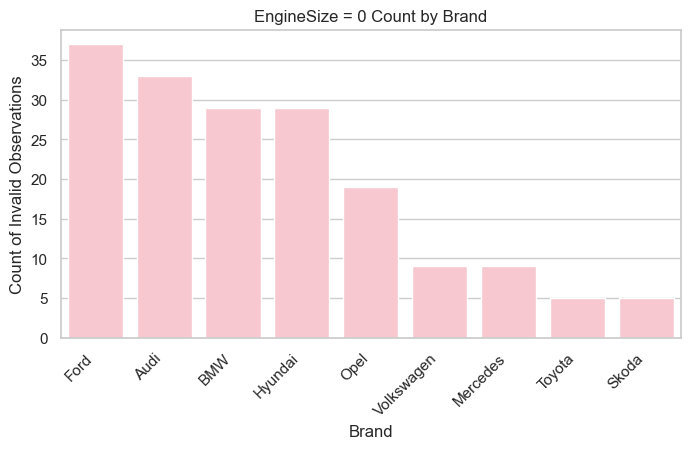

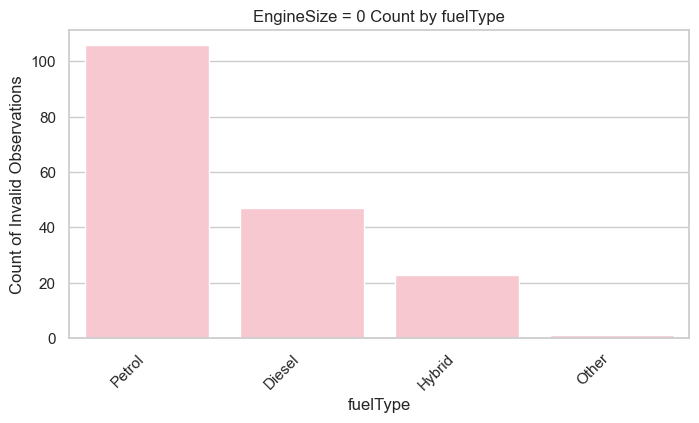

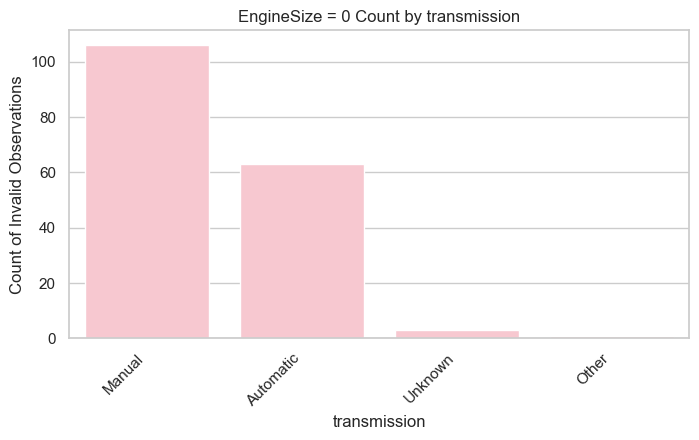

In [159]:
categorical_cols = ['Brand', 'fuelType', 'transmission'] 

for col in categorical_cols:
    invalid_counts = filtered[col].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=invalid_counts.index, y=invalid_counts.values, color='pink')
    plt.title(f'EngineSize = 0 Count by {col}')
    plt.xlabel(col)
    plt.ylabel('Count of Invalid Observations')
    plt.xticks(rotation=45, ha='right')
    plt.show()

<h3 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
HasDamage = 0 vs NA
</h3>

First we will start by visualizing numerical variables across these two groups to see if there is any difference. We will use the variables that would be mostly correlated with damage of the car - price, previous owners, year, paint quality

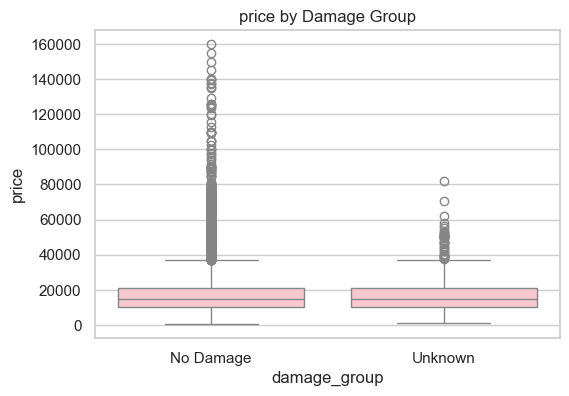

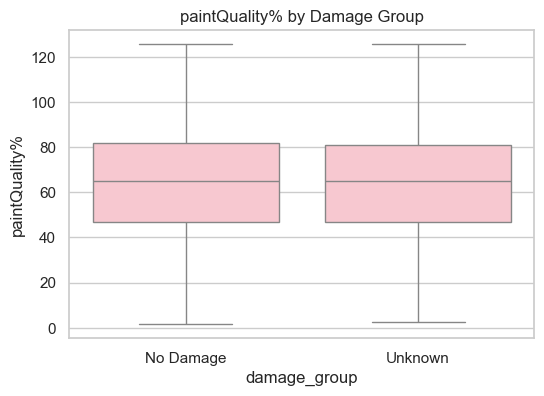

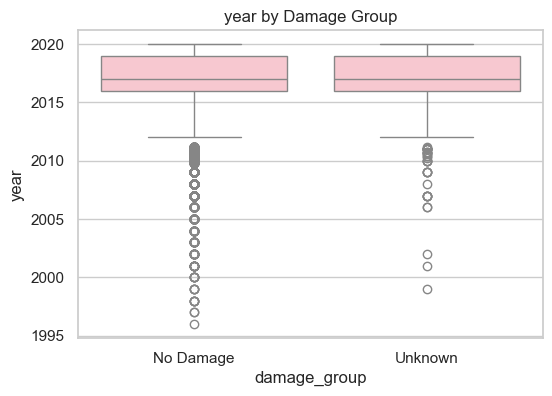

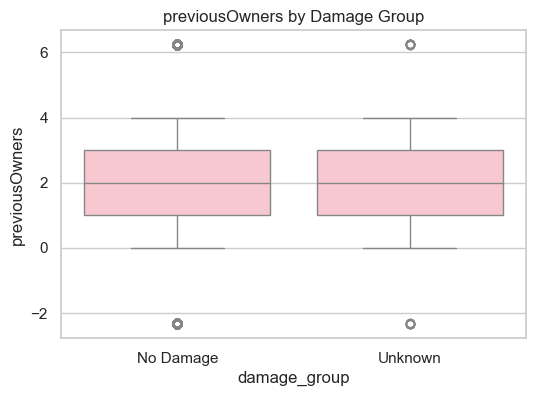

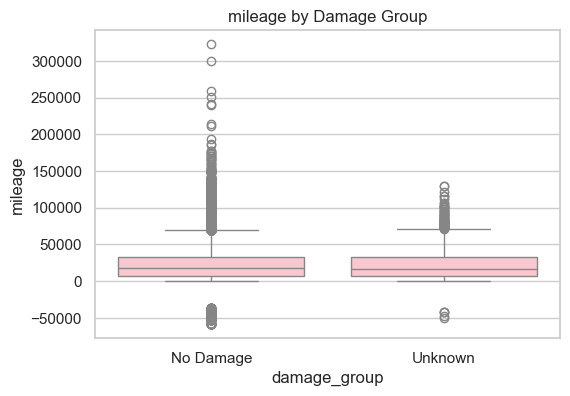

In [136]:
# Creating a categorical version of hasDamage
df_cars_train['damage_group'] = 'Unknown'                      
df_cars_train.loc[df_cars_train['hasDamage'].eq(False), 'damage_group'] = 'No Damage'
# This marks everything as Unknown and then sets No Damage where the series equals False

numeric_vars = ['price', 'paintQuality%', 'year', 'previousOwners', 'mileage']

for col in numeric_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='damage_group', y=col, data=df_cars_train, color='pink')
    plt.title(f'{col} by Damage Group')
    plt.show()

There seems to be no obvious difference between the cars that don't have damage and the unknown.  Let's check for the other numeric variables and also the categorical.

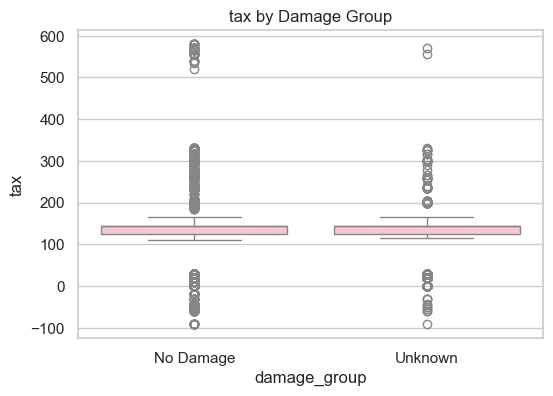

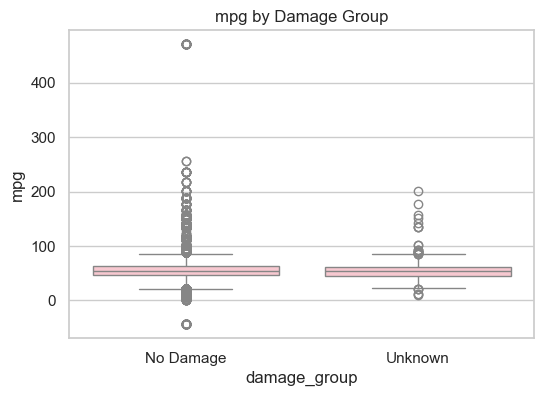

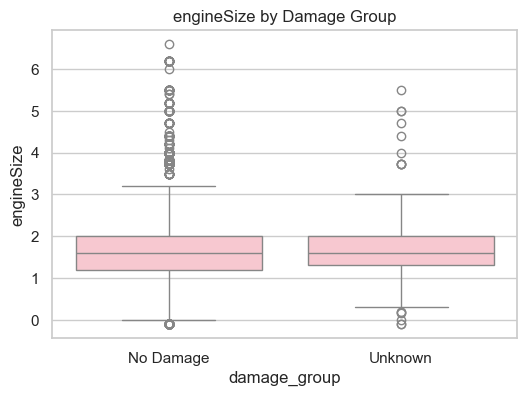

In [138]:
# ploting other numeric variables
numeric_vars = ['tax', 'mpg', 'engineSize']

for col in numeric_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='damage_group', y=col, data=df_cars_train, color='pink')
    plt.title(f'{col} by Damage Group')
    plt.show()

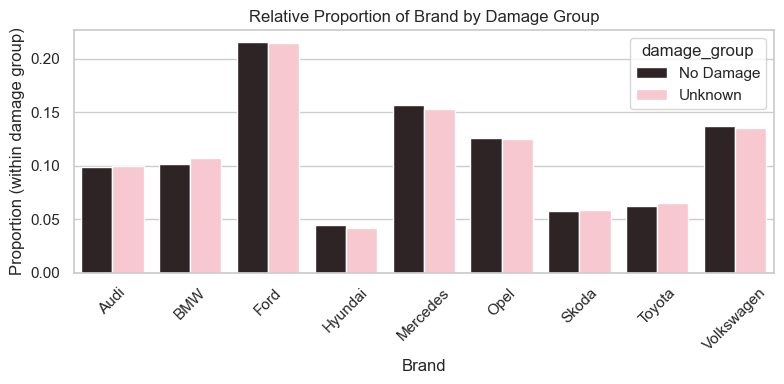

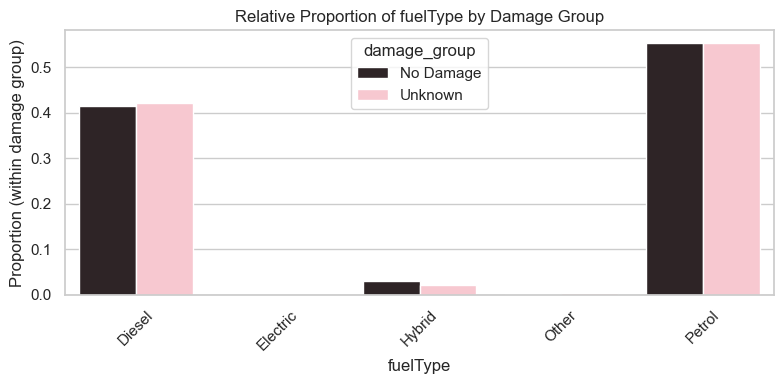

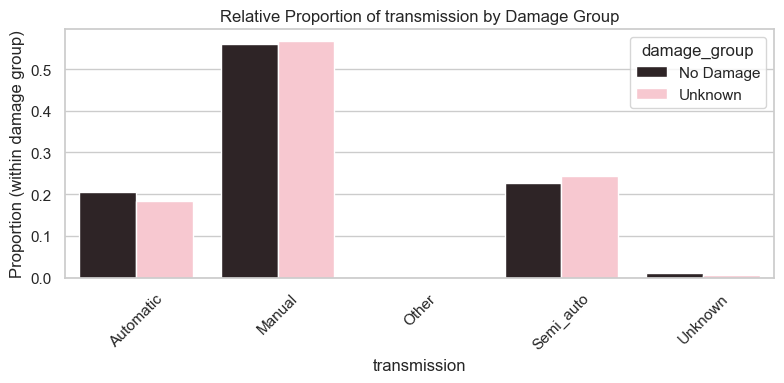

In [146]:
# categorical variables: Relative Frequency Bar Charts

cat_vars = ["Brand", "fuelType", "transmission"]


for col in cat_vars:
    grouped = df_cars_train.groupby(['damage_group', col]).size().to_frame('count').reset_index()

    grouped['proportion'] = (
        grouped['count'] / grouped.groupby('damage_group')['count'].transform('sum')
    )

    plt.figure(figsize=(8,4))
    sns.barplot(data=grouped, x=col, y='proportion', hue='damage_group', palette='dark:pink')
    plt.title(f'Relative Proportion of {col} by Damage Group')
    plt.ylabel('Proportion (within damage group)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Every distribution looks the identical for HasDamage = 0 vs hasDamage. As there are no significant differences, this leads us to believe that NAs behave the same way as 0's, so they should be computed as 0's. As a result, the whole column of hasDamage would contain only 0's, making it an irrelevant variable for the prediction of the price, as it always holds the same value.

<h1 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Fill Missing Values
</h1>

- *Year*

We want to input the NA in 'year' by doing a regression with the variables that are most correlated with it

In [150]:
# Calculate the correlation with numeric variables
numeric_vars = ['tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'mileage', 'year']

# Drop rows where year is missing
corrs = df_cars_train[numeric_vars].dropna(subset=['year']).corr()['year'].sort_values(ascending=False)
corrs

year              1.000000
tax               0.186152
paintQuality%     0.003782
previousOwners    0.000539
engineSize       -0.040248
mpg              -0.126342
mileage          -0.689332
Name: year, dtype: float64

The variable that is most correlated with year is 'mileage'. All the other correlations are very weak and shouldn't be considered.

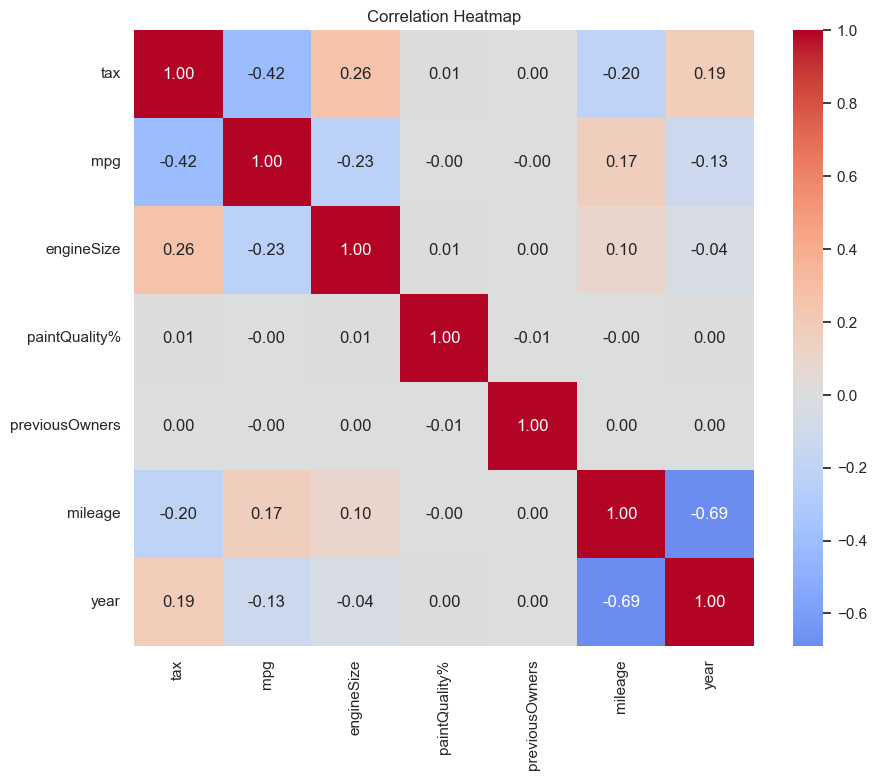

In [156]:
# Visualize the correlations
corr_matrix = df_cars_train[numeric_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

We can see that there are no strong correlations between the numeric variables, meaning that we can't do linear regressions to input NAs. We will have to use central tendency measures.

<h1 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Outliers
</h1>

<h2 style="background-color:#87CEFA; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Set theoretical limits for the variables 
</h2>

- **Mileage** : the theoretical limit is 30k/year, so we compute the max possible mileage as the age of the car * 30 000. Any car that exceeds that mileage is considered above the theoretical limit

In [ ]:
df_cars_train["max_possible_mileage"] = (2021 - df_cars_train['year']) * 30000
df_cars_train[df_cars_train['mileage'] > df_cars_train['max_possible_mileage']]

- **Tax** : It depends on vehicle type. For small petrol/diesel cars the max is 150, larger engines or luxury cars 500, and very-high emission cars (large SUVs) 2000, so we consider an outlier any tax > 2000 or negative

In [ ]:
df_cars_train[(df_cars_train["tax"]>2000) | (df_cars_train["tax"]<0)] 

- **mpg** : anything beyond 120 mpg and 5 mpg is implausible 

In [ ]:
df_cars_train[(df_cars_train["mpg"]<5) | (df_cars_train["mpg"]>120)] 

- **EngineSize** : small cars 0.8-1.4 // common range 1.0-3.0 // large SUVs and sports cars up to 6.0 // rare supercars up to 8.0, so the limit will be 0.6-8.0

In [ ]:
df_cars_train[(df_cars_train["engineSize"]<0.6) | (df_cars_train["engineSize"]>8.0)] 

<h1 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Feature Engineering
</h1>

<h1 style="background-color:#F08080; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
    Variable Selection
</h1>